# Introduction

Machine Learning has many fields where it can have powerful impact. Healthcare is one of the fields that can benefit mostly by using ML. Advancement in ML has created possibilities of automating challenging tasks in healthcare sector like detection of diseases, estimating risk, monitoring treatment etc which were posible before. One of the challenging task in healthcare is analyzing X-ray images. Chest X-rays can be used to detect many diseases like early-stage lung cancers, pneumonia and more. Failing to detect them might cause serious effect for patients. In 2017, 2.5M people died from pneumonia worldwide (source: https://ourworldindata.org/pneumonia). The death rate can be reduce if the patients are diagnosed and brought under treatment in time. Deploying Machine Learning models to detect diseases like these can improve the survival rate of the patients and save thousands of life.


## Dataset
One of the most common public dataset of chest X-rays is “ChestX-ray8” dataset. This dataset contains over 100k frontal-view X-ray images of more than 30k unique patients. The images have nine labels which includes Atelectasis, Cardiomegaly, Effusion, Infiltration, Mass, Nodule, Pneumonia, Pneumathorax and No Finding. Dataset link: https://arxiv.org/abs/1705.02315

In this notebook, I am going to explore the "ChestX-ray8" dataset and create the train, validation and test dataset for training Pneumonia Detection Model.

In [22]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
# load the csv file
dataset = pd.read_csv("Data_Entry_2017_v2020.csv")

In [24]:
dataset.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


Let's see the distribution of Age and Gender in our data.

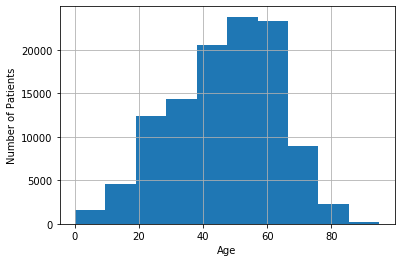

In [26]:
# histogram of Age distribution
dataset['Patient Age'].hist()
plt.xlabel("Age")
plt.ylabel("Number of Patients")
plt.show()

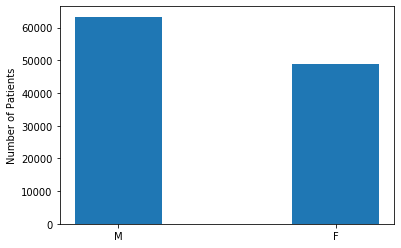

In [27]:
# bar plot for Male and Female patients
x = ['M','F']
y = [(dataset['Patient Gender'] == 'M').sum(), (dataset['Patient Gender'] == 'F').sum()]
plt.bar(x, y, width = 0.4)
plt.ylabel("Number of Patients")
plt.show()

Most of the patients are between 40-65 years. Also most patients in the dataset are Male, though number of female patient isn't significantly lower either. 

For my project, I will need only the 'Image Index', 'Finding Labels' and 'Patient ID' columns. So I will select only these three columns and discard other columns.

In [6]:
dataset = dataset[[ 'Image Index', 'Finding Labels', 'Patient ID' ]]

Next, I will select only the entries that have Pneumonia and label them as 1. The other entries will be labeled as 0.

In [7]:
# find the entries that have Pneumonia
pneumonia = dataset[dataset["Finding Labels"].str.contains('Pneumonia')].copy()

# set the labels to 1 (positive sample)
pneumonia['Finding Labels'] = 1

pneumonia.head()

,Image Index,Finding Labels,Patient ID
73,00000013_010.png,1,13
126,00000032_012.png,1,32
253,00000056_000.png,1,56
276,00000061_012.png,1,61
279,00000061_015.png,1,61


In [8]:
# find the entries that don't have Pneumonia
not_pneumonia = dataset[~dataset["Finding Labels"].str.contains('Pneumonia')].copy()

# set the labels to 0 (negative sample)
not_pneumonia['Finding Labels'] = 0

not_pneumonia.head()

,Image Index,Finding Labels,Patient ID
0,00000001_000.png,0,1
1,00000001_001.png,0,1
2,00000001_002.png,0,1
3,00000002_000.png,0,2
4,00000003_001.png,0,3


In [9]:
# merging the two dataset
pneumonia_dataset = pd.concat([pneumonia, not_pneumonia], axis=0)
pneumonia_dataset = pneumonia_dataset.sort_index()
pneumonia_dataset

,Image Index,Finding Labels,Patient ID
0,00000001_000.png,0,1
1,00000001_001.png,0,1
2,00000001_002.png,0,1
3,00000002_000.png,0,2
4,00000003_001.png,0,3
...,...,...,...
112115,00030801_001.png,1,30801
112116,00030802_000.png,0,30802
112117,00030803_000.png,0,30803
112118,00030804_000.png,0,30804


## Creating train, validation and test dataset

First, let's check the fraction of Pneumonia samples and Not Pneumonia samples in our dataset.

In [10]:
def count_class(series):
    """
    Given a series of binary values, return the count of 1 and 0
    """
    pos = series.sum()
    neg = series.shape[0] - pos
    return pos, neg

Total samples: 112120
Fraction of Pneumonia samples:  0.0128
Fraction of Normal samples:  0.9872
Ratio:  0.0129


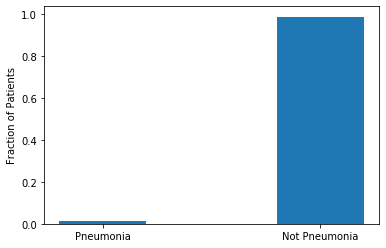

In [29]:
# calculating class imbalance
n_pneumonia, n_not_pneumonia = count_class(pneumonia_dataset["Finding Labels"])
n_total = pneumonia_dataset.shape[0]

frac_pneumonia = n_pneumonia / n_total
frac_not_pneumonia = n_not_pneumonia / n_total

ratio = n_pneumonia / n_not_pneumonia

print(f"Total samples: {n_total}")
print(f"Fraction of Pneumonia samples: {frac_pneumonia: .4f}")
print(f"Fraction of Normal samples: {frac_not_pneumonia: .4f}")
print(f"Ratio: {ratio: .4f}")

# bar plot
# bar plot for Male and Female patients
x = ['Pneumonia','Not Pneumonia']
y = [frac_pneumonia, frac_not_pneumonia]
plt.bar(x, y, width = 0.4)
plt.ylabel("Fraction of Patients")
plt.show()

As, there is a huge class imbalance, randomly splitting the dataset might end up giving test or validation set with no sample of Pneumonia.

Also, for medical datasets, it is necessary to ensure that the train, validation and test dataset don't contain the same patient's data. So let's check if the dataset contains several entries for the same patient.

In [12]:
n_unique_patients = len(set(pneumonia_dataset['Patient ID'].values))

print(f"Number of unique patients: {n_unique_patients}")
print(f"Number of entries: {n_total}")

Number of unique patients: 30805
Number of entries: 112120


As the number of unique patients is less than total entries, there is obviously several entries for the same patient.

Let's also check if Pneumonia dataset and Not Pneumonia dataset have any common patient (i.e. patients recovered from Pneumonia or diagnosed with pneumonia later).

In [13]:
# unique patient ids (pid)
pneumonia_pid = set(pneumonia['Patient ID'].values)
not_pneumonia_pid = set(not_pneumonia['Patient ID'].values)
common_pid = pneumonia_pid.intersection(not_pneumonia_pid)

print(f"Number of patients having Pneumonia: {len(pneumonia_pid)}")
print(f"Number of patients not having Pneumonia: {len(not_pneumonia_pid)}")
print(f"Common patients in both dataset: {len(common_pid)}")

Number of patients having Pneumonia: 1008
Number of patients not having Pneumonia: 30725
Common patients in both dataset: 928


There are 29797 (= 30725 - 928) patients who never had pneumonia. If I split only the patient IDs and create datasets based on the splitted patient IDs, the validation or test dataset might end up having no sample of pneumonia. So to ensure that all the splitted datasets have some samples of pneumonia, I will first split the pneumonia patients and then fill the splitted datasets with not pneumonia entries.

This will be done in the "train_val_test_split" function. For that function, first I will define a helper function named "split_dataset" in the next cell.

In [14]:
def split_dataframe(df, pid_list, fracs):
    """
    Returns three dataframes containing the entries of the patients who
    are splitted based on the given fractions    
    """

    train_frac, val_frac, test_frac = fracs

    ## calculate length
    to_train = round(len(pid_list) * train_frac)
    to_val = round(len(pid_list) * val_frac)
    to_test = round(len(pid_list) * train_frac)

    ## distribute the common pids 
    train_pid = pid_list[ : to_train]
    val_pid = pid_list[to_train : to_train+to_val]
    test_pid = pid_list[to_train+to_val : to_train+to_val+to_test]

    ## create dataframes with corresponding common pids
    train_set = df[df['Patient ID'].isin(train_pid)]
    val_set = df[df['Patient ID'].isin(val_pid)]
    test_set = df[df['Patient ID'].isin(test_pid)]

    return train_set, val_set, test_set


In [15]:
from random import shuffle, seed

def train_val_test_split(fracs, df=pneumonia_dataset, pneumonia_pid=pneumonia_pid,
                         not_pneumonia_pid=not_pneumonia_pid, common_pid = common_pid, random_seed=1):
    """
    Splits the given dataframe based on patients IDs
    Inputs:
        frac: touple of train, validation and test fraction
        df: dataframe to be splitted
        pneumonia_pid: set of pneumonia patient IDs
        not_pneumonia_pid: set of not pneumonia patient IDs, 
        common_pid: set of IDs of patients who are common in both pneumonia and not pneumonia entres, 
        random_seed: seed for random
        
    Returns: train, validation and testset as Dataframe
    """
    
    assert(fracs[0] + fracs[1] + fracs[2] <= 1), "Total of train, val and test fraction exeeds 1"
    seed(random_seed)
    
    # convert to list
    unique_pneumonia_pid = list(pneumonia_pid - common_pid) # they only appear in pneumonia samples
    unique_not_pneumonia_pid = list(not_pneumonia_pid - common_pid) # they only appear in not pneumonia samples
    common_pid = list(common_pid)
    
    # first, split the patiets that are common in both Pneumonia and Not Pneumonia dataset
    shuffle(common_pid)
    train_set, val_set, test_set = split_dataframe(df, common_pid, fracs)
    
    # now, split the patiets that are unique in Pneumonia and Not Pneumonia dataset
    shuffle(unique_pneumonia_pid)
    shuffle(unique_not_pneumonia_pid)
    
    train_set_2, val_set_2, test_set_2 = split_dataframe(df, unique_pneumonia_pid, fracs)
    train_set_3, val_set_3, test_set_3 = split_dataframe(df, unique_not_pneumonia_pid, fracs)

    # concat the respencitve dataframes
    train_set = pd.concat([train_set, train_set_2, train_set_3], axis=0)
    val_set = pd.concat([val_set, val_set_2, val_set_3], axis=0)
    test_set = pd.concat([test_set, test_set_2, test_set_3], axis=0)
    
    return train_set, val_set, test_set

In [16]:
# split dataset
train_set, val_set, test_set = train_val_test_split((0.85, 0.13, 0.02))

In [17]:
pos, neg = count_class(train_set["Finding Labels"])
print(f"In train set, Positive sample: {pos}, Negative sample: {neg}, Ratio: {pos/neg: 0.4f}")
pos, neg = count_class(val_set["Finding Labels"])
print(f"In validation set, Positive sample: {pos}, Negative sample: {neg}, Ratio: {pos/neg: 0.4f}")
pos, neg = count_class(test_set["Finding Labels"])
print(f"In test set, Positive sample: {pos}, Negative sample: {neg}, Ratio: {pos/neg: 0.4f}")

In train set, Positive sample: 1237, Negative sample: 94264, Ratio:  0.0131
In validation set, Positive sample: 169, Negative sample: 14262, Ratio:  0.0118
In test set, Positive sample: 25, Negative sample: 2163, Ratio:  0.0116


Let's save the train, val and test sets to a csv file which will be used in other notebooks.

In [18]:
train_set.to_csv("train.csv", index=False)
val_set.to_csv("validation.csv", index=False)
test_set.to_csv("test.csv", index=False)

Next, in the 2nd notebook, I will get the image files and prepare them for the model.

In [20]:
pneumonia.shape

(1431, 3)